# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
%load_ext autoreload
%autoreload 2
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, match_pair
from lightglue import viz2d
from pathlib import Path
import torch
images = Path('assets')

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device=torch.device('cuda')

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
match_conf = {
    'width_confidence': 0.99,  # for point pruning
    'depth_confidence': 0.95,  # for early stopping,
}
matcher = LightGlue(pretrained='superpoint', **match_conf).eval().to(device)

Loaded SuperPoint model
Loaded LightGlue model


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

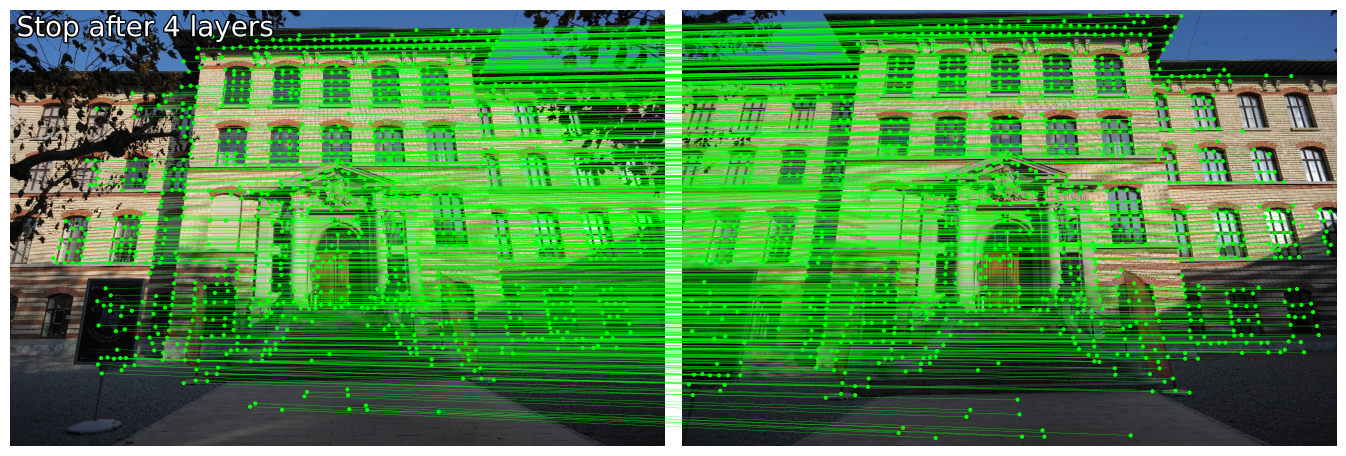

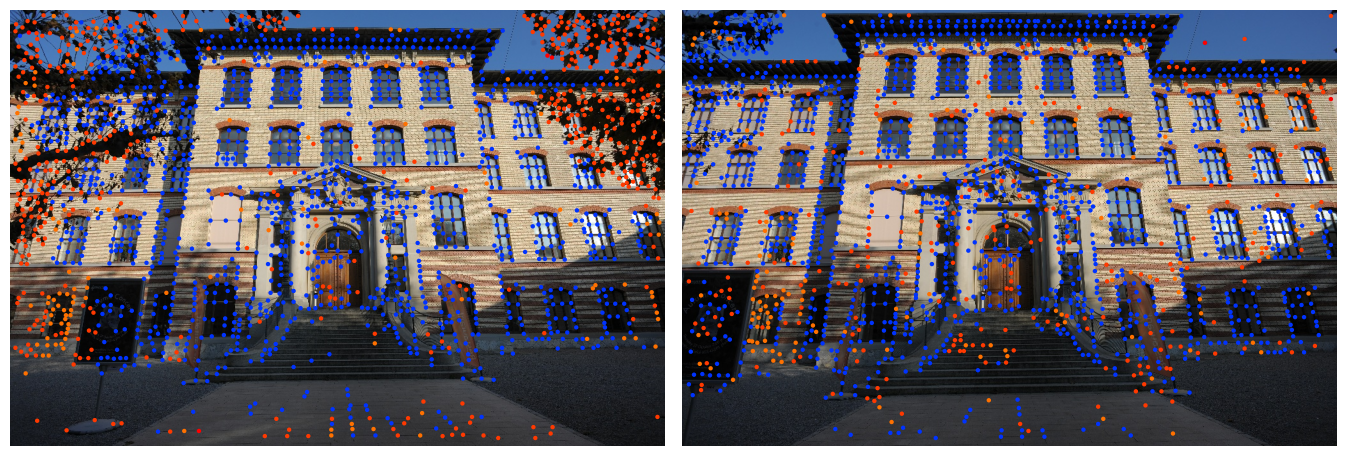

In [3]:
image0, scales0 = load_image(images / 'DSC_0411.JPG', resize=1024, grayscale=False)
image1, scales1 = load_image(images / 'DSC_0410.JPG', resize=1024, grayscale=False)

feats0, feats1, matches01 = match_pair(extractor, matcher, image0.to(device), image1.to(device))

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

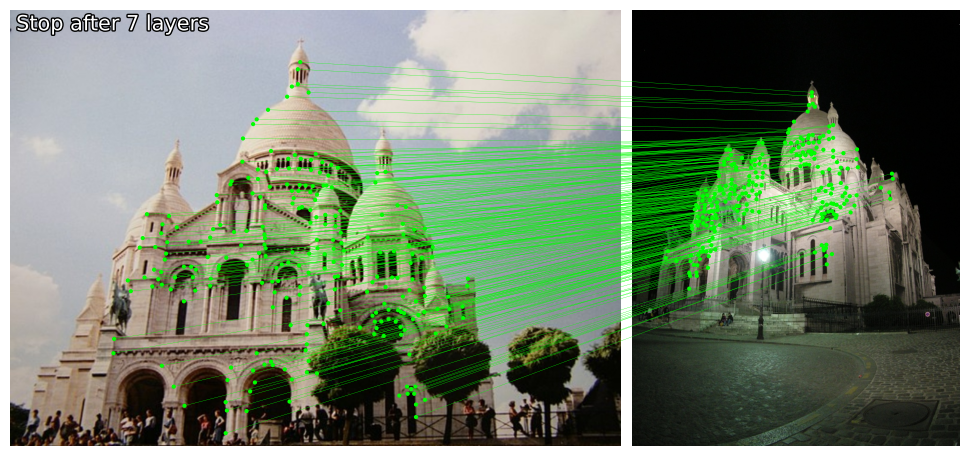

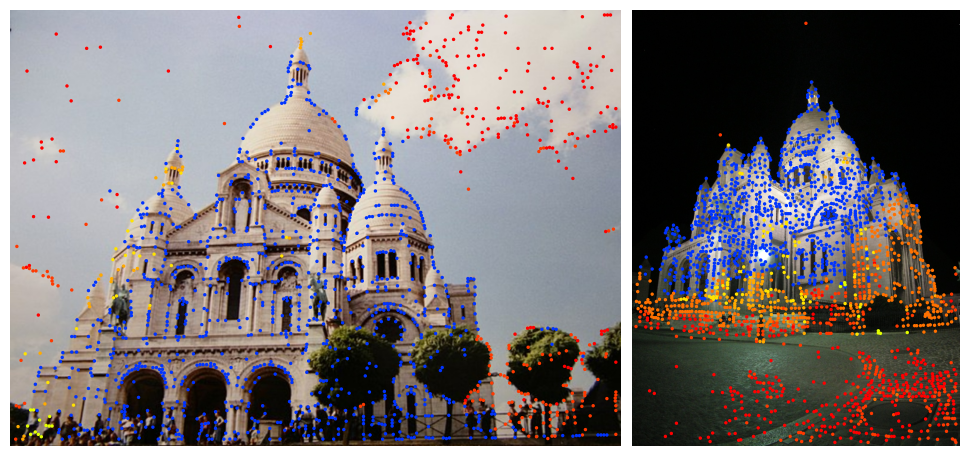

In [4]:
image0, sc0 = load_image(images / 'sacre_coeur1.jpg', resize=1024, grayscale=False)
image1, sc1 = load_image(images / 'sacre_coeur2.jpg', resize=1024, grayscale=False)

feats0, feats1, matches01 = match_pair(extractor, matcher, image0.to(device), image1.to(device))

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0.permute(1, 2, 0), image1.permute(1, 2, 0)])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)